In [1]:
import os
import random
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
import seaborn as sns
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
plt.style.use('seaborn-deep')

from shutil import rmtree
from itertools import islice
from sklearn.neighbors import KNeighborsClassifier

%matplotlib inline

# Task 1

In [2]:
from data_preparation import read_images, un_normalize
from model import get_model, get_batch, similarity, gen_train_input_fn, get_hist, eval_model

## Loading Data

In [6]:
N_CLASSES = 5

coarse = read_images('dataset/coarse/')
fine = read_images('dataset/fine/')
real = read_images('dataset/real/')
train_idxs = ()
with open('dataset/real/training_split.txt') as f:
    train_idxs = set(int(x) for x in f.read().split(', '))

In [7]:
Sdb    = coarse
Strain = fine + [s for s in real
                    if s.idx in train_idxs]
Stest  = [s for s in real
                    if s.idx not in train_idxs]
Dataset = {
    'Sdb': Sdb,
    'Strain': Strain,
    'Stest': Stest
}

In [8]:
print(len(Sdb), len(Strain), len(Stest))

1335 7410 3535


## Batch Generator

In [9]:
def get_batch_(Sdb, Strain, verbose = True):
    """
    Generates a batch of `n` elements
    """
    def gen():
        anchors = Strain[:]
        while True:
            if verbose: print('Shuffling dataset')
            random.shuffle(anchors)
            
            for anchor in anchors:
                # Anchor: select random sample from Strain
                #anchor = random.choice(Strain)
                # Puller: select most similar from Sdb
                puller = min( (x for x in Sdb if x.cls == anchor.cls)
                            , key = lambda x: similarity(x.quat,anchor.quat))
                # Pusher: same object different pose | random different object 
                pusher = random.choice([x for x in Sdb 
                                        if (x.cls != anchor.cls) or (x.cls == anchor.cls and x.idx != anchor.idx) ])
                yield (anchor.img, anchor.cls)
                yield (puller.img, puller.cls)
                yield (pusher.img, pusher.cls)
    return gen

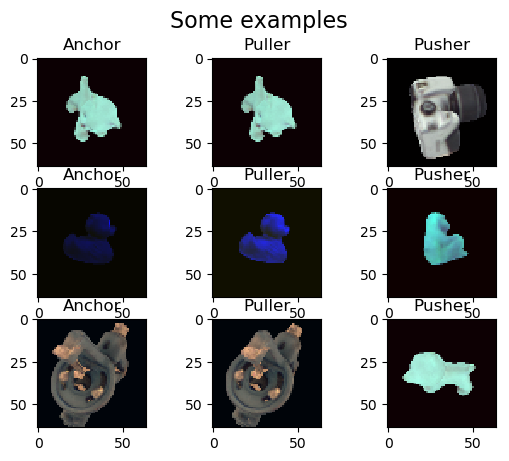

In [11]:
N = 3
imgs = islice((un_normalize(x) for x,_ in get_batch(Sdb, Strain, False)()),9)
with plt.style.context('default'):
    fig, ax = plt.subplots(N,3)
    for i in range(N):
        fig.suptitle('Some examples', fontsize=16)
        ax[i,0].set_title('Anchor')
        ax[i,0].imshow(next(imgs))
        ax[i,1].set_title('Puller')
        ax[i,1].imshow(next(imgs))
        ax[i,2].set_title('Pusher')
        ax[i,2].imshow(next(imgs))

# Task 2

Creating the neural network

### Cache

In [52]:
if __name__ == '__main__':
    CACHE_DIR = 'cache/'
    rmtree(CACHE_DIR)
    os.makedirs(CACHE_DIR)
    MODEL_PATH = os.path.join(CACHE_DIR,'cnn_model')
    INPUT_PATH = os.path.join(CACHE_DIR,'cnn_input')
    os.makedirs(MODEL_PATH)
    os.makedirs(INPUT_PATH)

In [58]:
# parameters
BATCH_SIZE = 30
EPOCHS = 20
MAX_STEPS  = int(len(Strain) * EPOCHS / BATCH_SIZE)

In [61]:
print('Preparing model...', end='')
cnn_descriptor = get_model(Dataset)
hists = []
print('\rModel trained.')
print('Executing model')
with open('hists.csv', 'w+') as f:
    f.write('epochs,<10,<20,<40,<180\n')

tensors_to_log = [
    'triplet_loss',
    'pair_loss',
    'full_loss'
]
logging_hook = tf.train.LoggingTensorHook(
    tensors=tensors_to_log, every_n_iter=10)

input_fn = gen_train_input_fn(Sdb, Strain, BATCH_SIZE)
for x in range(1,MAX_STEPS+2, 1000):
    print('Step {}/{}'.format(x, MAX_STEPS))
    cnn_descriptor.train(
        input_fn=input_fn,
        max_steps=x
    )
    
    hist = 100 * get_hist(cnn_descriptor, Sdb, Stest) / len(Stest)
    print(hist)
    with open('hists.csv', 'a+') as f:
        arr = [str(x)] + list(map(str,hist))
        f.write(','.join(arr) + '\n')


Preparing model...INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'cache/cnn_model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1a7270cc18>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Model trained.
Executing model
Step 1/5000
INFO:tensorflow:Skipping training since max_steps has already saved.
INFO:tensorflo

INFO:tensorflow:Restoring parameters from cache/cnn_model/model.ckpt-3001
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 3001 into cache/cnn_model/model.ckpt.
Shuffling dataset
INFO:tensorflow:loss = 0.5086471, step = 3002
INFO:tensorflow:global_step/sec: 10.2296
INFO:tensorflow:loss = 0.9402971, step = 3102 (9.777 sec)
INFO:tensorflow:global_step/sec: 10.7038
INFO:tensorflow:loss = 1.2143006, step = 3202 (9.342 sec)
INFO:tensorflow:global_step/sec: 10.6805
INFO:tensorflow:loss = 0.28078932, step = 3302 (9.363 sec)
INFO:tensorflow:global_step/sec: 10.7146
INFO:tensorflow:loss = 0.5406594, step = 3402 (9.333 sec)
INFO:tensorflow:global_step/sec: 10.7206
INFO:tensorflow:loss = 1.1385093, step = 3502 (9.328 sec)
INFO:tensorflow:global_step/sec: 10.7075
INFO:tensorflow:loss = 1.0450166, step = 3602 (9.338 sec)
INFO:tensorflow:global_step/sec: 10.7376
INFO:tensorflow:loss = 0.7171175, step = 3702 (9.313 sec)
Shufflin

# Task 3

In [183]:
df = pd.read_csv('hists.csv')
df

,epochs,<10,<20,<40,<180
0,1,0.169731,1.046676,4.186704,21.103253
1,1001,0.339463,1.301273,5.063649,29.561528
2,2001,0.480905,1.923621,7.864215,42.149929
3,3001,0.792079,3.536068,12.305516,42.291372
4,4001,0.933522,3.734088,13.521924,51.966054


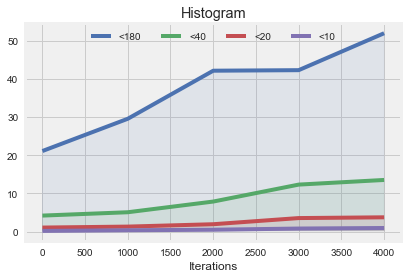

In [176]:
def plot_histograms(filename = 'hists.csv', aslog = False):
    df = pd.read_csv(filename)
    fig, ax = plt.subplots()
    
    cols = df.columns[1:]
    
    if aslog:
        df[cols] = np.log(df[cols])
    
    minimum = df[cols].min().min()
    for col in sorted(cols, key = lambda c: df[c].max(), reverse = True):
        line, = ax.plot(df.epochs, df[col], label=col)
        verts = [(df.epochs.min(), minimum), *zip(df.epochs, df[col]), (df.epochs.max(), minimum)]
        poly = Polygon(verts, color = line.get_color(), alpha = 0.1)
        ax.add_patch(poly)
        
    ax.set_title('Histogram')
    ax.set_xlabel('Iterations')
    ax.legend(loc = 'upper center', ncol = 4)
    return fig, ax
fig, ax = plot_histograms(aslog = False)
fig.savefig('histograms.png', dpi=300)

In [181]:
def plot_confusion_matrix(model, Sdb, Stest):
    neigh = KNeighborsClassifier(n_neighbors=1)

    Sdb_descriptors, Stest_descriptors = eval_model(model, Sdb, Stest)
    X, y = Sdb_descriptors, [x.cls for x in Sdb]
    neigh.fit(X,y)

    idxs = neigh.kneighbors(Stest_descriptors)[1]

    matrix = np.zeros([N_CLASSES, N_CLASSES])
    N = len(Stest_descriptors)
    for i in range(N):
        db = Sdb[idxs[i][0]]
        test = Stest[i]
        
        cls_true = db.cls
        cls_pred = test.cls
        matrix[cls_true,cls_pred] += 1
    
    # plot here
        
    matrix = matrix/N
    print(matrix)
    return sns.heatmap(matrix)
plot_confusion_matrix(cnn_descriptor, Sdb, Strain)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from cache/cnn_model/projection_test_descriptors.ckpt


NotFoundError: Restoring from checkpoint failed. This is most likely due to a Variable name or other graph key that is missing from the checkpoint. Please ensure that you have not altered the graph expected based on the checkpoint. Original error:

Key conv2d/bias not found in checkpoint
	 [[node save/RestoreV2 (defined at /Users/kanales/Documents/Uni/TDCV/exercise03/model.py:200)  = RestoreV2[dtypes=[DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_INT64], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_save/Const_0_0, save/RestoreV2/tensor_names, save/RestoreV2/shape_and_slices)]]

Caused by op 'save/RestoreV2', defined at:
  File "/anaconda3/envs/ex3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/anaconda3/envs/ex3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/anaconda3/envs/ex3/lib/python3.6/asyncio/base_events.py", line 438, in run_forever
    self._run_once()
  File "/anaconda3/envs/ex3/lib/python3.6/asyncio/base_events.py", line 1451, in _run_once
    handle._run()
  File "/anaconda3/envs/ex3/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tornado/gen.py", line 1233, in inner
    self.run()
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tornado/gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 370, in dispatch_queue
    yield self.process_one()
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tornado/gen.py", line 346, in wrapper
    runner = Runner(result, future, yielded)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tornado/gen.py", line 1080, in __init__
    self.run()
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tornado/gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2819, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2845, in _run_cell
    return runner(coro)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3020, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3191, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-181-75e9fdf403e9>", line 25, in <module>
    plot_confusion_matrix(cnn_descriptor, Sdb, Strain)
  File "<ipython-input-181-75e9fdf403e9>", line 4, in plot_confusion_matrix
    Sdb_descriptors, Stest_descriptors = eval_model(model, Sdb, Stest)
  File "/Users/kanales/Documents/Uni/TDCV/exercise03/model.py", line 200, in eval_model
    Sdb_descriptors = list(model.predict(input_fn=eval_input_fn))
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tensorflow/python/estimator/estimator.py", line 593, in predict
    hooks=all_hooks) as mon_sess:
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tensorflow/python/training/monitored_session.py", line 921, in __init__
    stop_grace_period_secs=stop_grace_period_secs)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tensorflow/python/training/monitored_session.py", line 643, in __init__
    self._sess = _RecoverableSession(self._coordinated_creator)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tensorflow/python/training/monitored_session.py", line 1107, in __init__
    _WrappedSession.__init__(self, self._create_session())
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tensorflow/python/training/monitored_session.py", line 1112, in _create_session
    return self._sess_creator.create_session()
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tensorflow/python/training/monitored_session.py", line 800, in create_session
    self.tf_sess = self._session_creator.create_session()
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tensorflow/python/training/monitored_session.py", line 557, in create_session
    self._scaffold.finalize()
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tensorflow/python/training/monitored_session.py", line 213, in finalize
    self._saver = training_saver._get_saver_or_default()  # pylint: disable=protected-access
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 886, in _get_saver_or_default
    saver = Saver(sharded=True, allow_empty=True)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1102, in __init__
    self.build()
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1114, in build
    self._build(self._filename, build_save=True, build_restore=True)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1151, in _build
    build_save=build_save, build_restore=build_restore)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 789, in _build_internal
    restore_sequentially, reshape)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 459, in _AddShardedRestoreOps
    name="restore_shard"))
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 406, in _AddRestoreOps
    restore_sequentially)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 862, in bulk_restore
    return io_ops.restore_v2(filename_tensor, names, slices, dtypes)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tensorflow/python/ops/gen_io_ops.py", line 1466, in restore_v2
    shape_and_slices=shape_and_slices, dtypes=dtypes, name=name)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3274, in create_op
    op_def=op_def)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1770, in __init__
    self._traceback = tf_stack.extract_stack()

NotFoundError (see above for traceback): Restoring from checkpoint failed. This is most likely due to a Variable name or other graph key that is missing from the checkpoint. Please ensure that you have not altered the graph expected based on the checkpoint. Original error:

Key conv2d/bias not found in checkpoint
	 [[node save/RestoreV2 (defined at /Users/kanales/Documents/Uni/TDCV/exercise03/model.py:200)  = RestoreV2[dtypes=[DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_INT64], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_save/Const_0_0, save/RestoreV2/tensor_names, save/RestoreV2/shape_and_slices)]]


In [182]:
def project_data(model, Stest):
    imgs, labs = zip(*[(x.img, x.cls) for x in Stest])
    imgarr = np.array(imgs)
    eval_input_fn = tf.estimator.inputs.numpy_input_fn(
        imgarr,
        shuffle=False,
    )
    descs = np.array(list(model.predict(eval_input_fn)))

    metadata = os.path.join(MODEL_PATH ,'projection_metadata.tsf')
    #descriptors = tf.convert_to_tensor(descs)
    images = tf.Variable(descs, name='test_descriptors')
    with open(metadata, 'w+') as f:
        for cls in labs:
            f.write(str(cls) + '\n')

    with tf.Session() as sess:
        saver = tf.train.Saver([images])
        sess.run(images.initializer)
        saver.save(sess, os.path.join(MODEL_PATH ,'projection_test_descriptors.ckpt'))
project_data(cnn_descriptor,Stest)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from cache/cnn_model/projection_test_descriptors.ckpt


NotFoundError: Restoring from checkpoint failed. This is most likely due to a Variable name or other graph key that is missing from the checkpoint. Please ensure that you have not altered the graph expected based on the checkpoint. Original error:

Key conv2d/bias not found in checkpoint
	 [[node save/RestoreV2 (defined at <ipython-input-182-5bdbc7765bf5>:8)  = RestoreV2[dtypes=[DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_INT64], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_save/Const_0_0, save/RestoreV2/tensor_names, save/RestoreV2/shape_and_slices)]]

Caused by op 'save/RestoreV2', defined at:
  File "/anaconda3/envs/ex3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/anaconda3/envs/ex3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/anaconda3/envs/ex3/lib/python3.6/asyncio/base_events.py", line 438, in run_forever
    self._run_once()
  File "/anaconda3/envs/ex3/lib/python3.6/asyncio/base_events.py", line 1451, in _run_once
    handle._run()
  File "/anaconda3/envs/ex3/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tornado/gen.py", line 1233, in inner
    self.run()
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tornado/gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2819, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2845, in _run_cell
    return runner(coro)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3020, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3191, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-182-5bdbc7765bf5>", line 21, in <module>
    project_data(cnn_descriptor,Stest)
  File "<ipython-input-182-5bdbc7765bf5>", line 8, in project_data
    descs = np.array(list(model.predict(eval_input_fn)))
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tensorflow/python/estimator/estimator.py", line 593, in predict
    hooks=all_hooks) as mon_sess:
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tensorflow/python/training/monitored_session.py", line 921, in __init__
    stop_grace_period_secs=stop_grace_period_secs)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tensorflow/python/training/monitored_session.py", line 643, in __init__
    self._sess = _RecoverableSession(self._coordinated_creator)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tensorflow/python/training/monitored_session.py", line 1107, in __init__
    _WrappedSession.__init__(self, self._create_session())
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tensorflow/python/training/monitored_session.py", line 1112, in _create_session
    return self._sess_creator.create_session()
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tensorflow/python/training/monitored_session.py", line 800, in create_session
    self.tf_sess = self._session_creator.create_session()
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tensorflow/python/training/monitored_session.py", line 557, in create_session
    self._scaffold.finalize()
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tensorflow/python/training/monitored_session.py", line 213, in finalize
    self._saver = training_saver._get_saver_or_default()  # pylint: disable=protected-access
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 886, in _get_saver_or_default
    saver = Saver(sharded=True, allow_empty=True)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1102, in __init__
    self.build()
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1114, in build
    self._build(self._filename, build_save=True, build_restore=True)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1151, in _build
    build_save=build_save, build_restore=build_restore)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 789, in _build_internal
    restore_sequentially, reshape)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 459, in _AddShardedRestoreOps
    name="restore_shard"))
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 406, in _AddRestoreOps
    restore_sequentially)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 862, in bulk_restore
    return io_ops.restore_v2(filename_tensor, names, slices, dtypes)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tensorflow/python/ops/gen_io_ops.py", line 1466, in restore_v2
    shape_and_slices=shape_and_slices, dtypes=dtypes, name=name)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3274, in create_op
    op_def=op_def)
  File "/anaconda3/envs/ex3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1770, in __init__
    self._traceback = tf_stack.extract_stack()

NotFoundError (see above for traceback): Restoring from checkpoint failed. This is most likely due to a Variable name or other graph key that is missing from the checkpoint. Please ensure that you have not altered the graph expected based on the checkpoint. Original error:

Key conv2d/bias not found in checkpoint
	 [[node save/RestoreV2 (defined at <ipython-input-182-5bdbc7765bf5>:8)  = RestoreV2[dtypes=[DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_INT64], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_save/Const_0_0, save/RestoreV2/tensor_names, save/RestoreV2/shape_and_slices)]]
